In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from BufferStockModel import ConSavModelClass
from FEmodel import FEModelClass


# Set the number of threads in numba
# nb.set_num_threads(4)

To add in the model
- Finite lifetime
- Individual $\beta$'s
- Individual innate ability
- Individual choice of level and shape

Solve the model

In [2]:
model = FEModelClass()

In [4]:
model.solve()

model solved in 0.1 secs


In [5]:
sol = model.sol
par = model.par

Plot the policy functions for $\alpha^l$ and $\alpha^s$ as a function of $\beta$ and $\tilde{\alpha}$

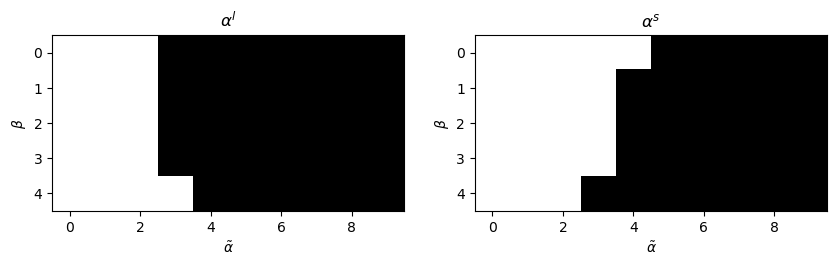

In [6]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)

ax.imshow(sol.alpha_l,cmap='binary')
ax.set_xlabel(r'$\tilde{\alpha}$')
ax.set_ylabel(r'$\beta$')
ax.set_title(r'$\alpha^l$')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(sol.alpha_s, cmap='binary')
ax2.set_xlabel(r'$\tilde{\alpha}$')
ax2.set_ylabel(r'$\beta$')
ax2.set_title(r'$\alpha^s$')

plt.show()

In [7]:
sol.alpha_l

array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.]])

Check how the policy functions look

Split by $\beta$

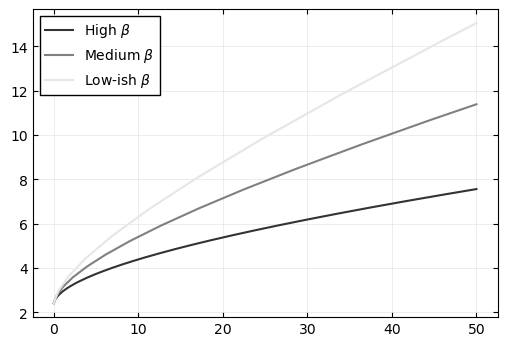

In [8]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(par.a_grid,sol.c[0,-1,-1,-1,-1,:], color = '0.2', label = r'High $\beta$',zorder=2)
ax.plot(par.a_grid,sol.c[0,-2,-1,-1,-1,:], color = '0.5', label = r'Medium $\beta$',zorder=2)
ax.plot(par.a_grid,sol.c[0,-3,-1,-1,-1,:], color = '0.9', label = r'Low-ish $\beta$',zorder=2)

# ax.set_ylim(0,2.1)
# ax.set_xlim(0,5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.show()

Split by $\alpha$

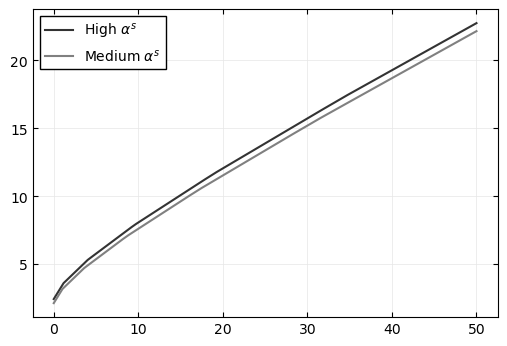

In [9]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(par.a_grid,sol.c[0,0,1,-1,-1,:], color = '0.2', label = r'High $\alpha^s$',zorder=2)
ax.plot(par.a_grid,sol.c[0,0,0,-1,-1,:], color = '0.5', label = r'Medium $\alpha^s$',zorder=2)
# ax.plot(par.a_grid,sol.c[0,-1,-1,-1,-1,:], color = '0.9', label = r'Low-ish $\beta$',zorder=2)

# ax.set_ylim(0,2.1)
# ax.set_xlim(0,5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.show()

In [ ]:
plt.plot(par.a_grid,sol.v[0,1,1,1,3,:])
plt.plot(par.a_grid,sol.v[0,1,1,1,2,:])

In [ ]:
expectation_exante = np.zeros((par.Nbeta,par.Nalpha_l,par.Nalpha_s))

# betas are assumed known before choice, so loop over them
for i_beta in range(par.Nbeta):

    # compute beginning of period expectation, using the ergodic distribution of productivity
    for i_z in range(par.Nz):

        # probability weight
        w = par.z_ergodic[i_z]

        # expected value, assuming life starts with zero assets
        expectation_exante[i_beta,:,:] += w*sol.v[0,i_beta,:,:,i_z,0]


In [ ]:
expectation_exante[-1]

In [ ]:
# weights of penalty terms
w_l = 2.0
w_s = 1.0

# loop over values of innate ability
val_of_choice = np.zeros((par.Nbeta,par.Nalpha_l,par.Nalpha_s)) # initialize
for i_beta in range(par.Nbeta):
    for i_alpha_tilde in [9]:
        for i_alpha_l in range(par.Nalpha_l):
            for i_alpha_s in range(par.Nalpha_s):

                # unpack states
                alpha_l = par.alpha_l_grid[i_alpha_l]
                alpha_s = par.alpha_s_grid[i_alpha_s]
                alpha_tilde = par.alpha_tilde_grid[i_alpha_tilde]

                # penalty term
                penalty = -1*(w_l*(alpha_l - alpha_tilde)**2 + w_s*(alpha_s - alpha_tilde))**2

                # value of choice of (alpha_l,alpha_s)
                val_of_choice[i_beta,i_alpha_l,i_alpha_s] = expectation_exante[i_beta,i_alpha_l,i_alpha_s] + penalty

In [ ]:
val_of_choice

In [ ]:
val_of_choice[0,:,:]

In [ ]:
np.unravel_index()

In [ ]:
x = np.unravel_index(np.argmax(val_of_choice[0,:,:],axis=None),val_of_choice[0,:,:].shape)
print(x)

In [ ]:
print(par.alpha_tilde_grid)

In [ ]:
plt.plot(par.a_grid,sol.c[0,0,2,:], color = '0.0') # Low beta
plt.plot(par.a_grid,sol.c[0,1,2,:], color = '0.2')
plt.plot(par.a_grid,sol.c[0,2,2,:], color = '0.4')
plt.plot(par.a_grid,sol.c[0,3,2,:], color = '0.6')
plt.plot(par.a_grid,sol.c[0,4,2,:], color = '0.8') # High beta

plt.show()

In [ ]:
sol.c.shape

In [ ]:
plt.plot(par.a_grid,sol.c[0,1,2,:], color = '0.2')

In [ ]:
H = 20
for h in reversed(range(H)):
    print(h)

In [ ]:
modelfe.par.z_ergodic

ValueError: x and y must have same first dimension, but have shapes (500,) and (10, 2, 2, 5, 500)

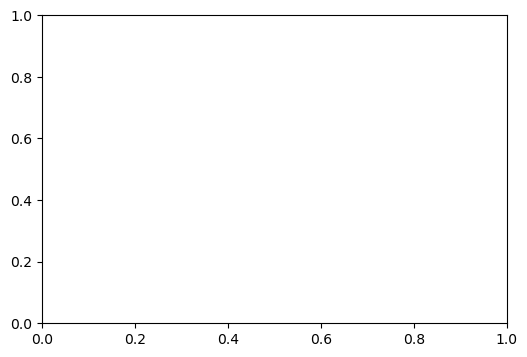

In [102]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)


ax.plot(par.a_grid,sol.c[0,:], color = '0.4', label = 'Low $p$',zorder=2)
ax.plot(par.a_grid,sol.c[3,:], color = '0.6', label = 'Medium $p$',zorder=2)
ax.plot(par.a_grid,sol.c[-1,:], color = '0.8', label = 'High $p$',zorder=2)


ax.set_ylim(0,2.1)
# ax.set_xlim(0,5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.show()